Anushna Prakash  
DATA 512 - Human-Centered Data Science  
October 5, 2021  
# A1 - Data Curation

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [2]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

## Part I: Data Acquisition

In [3]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [4]:
# Use first of September to get complete data thru August 1, 2021
end_date = '20210901' + '00'

params_legacy_desktop = {
    "project" : "en.wikipedia.org",
    "access-site" : "desktop-site",
    "granularity" : "monthly",
    "start" : "2001010100",
    # for end use 1st day of month following final month of data
    "end" : end_date
}

params_legacy_mobile = {
    "project" : "en.wikipedia.org",
    "access-site" : "mobile-site",
    "granularity" : "monthly",
    "start" : "2001010100",
    # for end use 1st day of month following final month of data
    "end" : end_date
}

params_pageviews_desktop = {
    "project" : "en.wikipedia.org",
    "access" : "desktop",
    "agent" : "user",
    "granularity" : "monthly",
    "start" : "2001010100",
    # for end use 1st day of month following final month of data
    "end" : end_date
}

params_pageviews_app = {
    "project" : "en.wikipedia.org",
    "access" : "mobile-app",
    "agent" : "user",
    "granularity" : "monthly",
    "start" : "2001010100",
    # for end use 1st day of month following final month of data
    "end" : end_date
}

params_pageviews_mobileweb = {
    "project" : "en.wikipedia.org",
    "access" : "mobile-web",
    "agent" : "user",
    "granularity" : "monthly",
    "start" : "2001010100",
    # for end use 1st day of month following final month of data
    "end" : end_date
}

headers = {
    'User-Agent': 'https://github.com/anushnap',
    'From': 'anushnap@uw.edu'
}

In [5]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [6]:
legacy_monthly_pageviews_desktop = api_call(endpoint_legacy, params_legacy_desktop)
legacy_monthly_pageviews_mobile = api_call(endpoint_legacy, params_legacy_mobile)
pageviews_monthly_pageviews_desktop = api_call(endpoint_pageviews, params_pageviews_desktop)
pageviews_monthly_pageviews_app = api_call(endpoint_pageviews, params_pageviews_app)
pageviews_monthly_pageviews_mobileweb = api_call(endpoint_pageviews, params_pageviews_mobileweb)

In [8]:
with open('./data_raw/legacy_desktop-site_200712-201607.json', 'w', encoding='utf-8') as f:
    json.dump(legacy_monthly_pageviews_desktop, f, ensure_ascii = False, indent=4)

with open('./data_raw/legacy_mobile-site_200712-201607.json', 'w', encoding='utf-8') as f:
    json.dump(legacy_monthly_pageviews_mobile, f, ensure_ascii = False, indent=4)

with open('./data_raw/pagecounts_desktop-site_200712-202108.json', 'w', encoding='utf-8') as f:
    json.dump(pageviews_monthly_pageviews_desktop, f, ensure_ascii = False, indent=4)

with open('./data_raw/pagecounts_mobile-web_200712-202108.json', 'w', encoding='utf-8') as f:
    json.dump(pageviews_monthly_pageviews_mobileweb, f, ensure_ascii = False, indent=4)

with open('./data_raw/pagecounts_mobile-app_200712-202108.json', 'w', encoding='utf-8') as f:
    json.dump(pageviews_monthly_pageviews_app, f, ensure_ascii = False, indent=4)

## Part 2: Data Processing

In [35]:
def clean_legacy(df):
    df['year'] = df['timestamp'].str.slice(start = 0, stop = 4).astype(int)
    df['month'] = df['timestamp'].str.slice(start = 4, stop = 6).astype(int)
    return df[['year', 'month', 'count']]

# Processing legacy API results
df_desktop = clean_legacy(pd.json_normalize(legacy_monthly_pageviews_desktop['items'])) 
# df_desktop = clean_df(df_desktop)
print(df_desktop.info())
df_mobile = clean_legacy(pd.json_normalize(legacy_monthly_pageviews_mobile['items']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    105 non-null    int64
 1   month   105 non-null    int64
 2   count   105 non-null    int64
dtypes: int64(3)
memory usage: 2.6 KB
None


In [36]:
df_legacy = df_desktop.merge(df_mobile, how = 'left', on = ['year', 'month'])\
    .rename(columns = {'count_x': 'pagecounts_desktop_views', 'count_y': 'pagecounts_mobile_views'})

In [37]:
df_legacy.fillna(0, inplace = True)
df_legacy['pagecounts_all_views'] = df_legacy['pagecounts_desktop_views'] + df_legacy['pagecounts_mobile_views']
df_legacy

,year,month,pagecounts_desktop_views,pagecounts_mobile_views,pagecounts_all_views
0,2007,12,2998331524,0.000000e+00,2.998332e+09
1,2008,1,4930902570,0.000000e+00,4.930903e+09
2,2008,2,4818393763,0.000000e+00,4.818394e+09
3,2008,3,4955405809,0.000000e+00,4.955406e+09
4,2008,4,5159162183,0.000000e+00,5.159162e+09
...,...,...,...,...,...
100,2016,4,5572235399,3.301385e+09,8.873621e+09
101,2016,5,5330532334,3.418436e+09,8.748968e+09
102,2016,6,4975092447,3.372618e+09,8.347711e+09
103,2016,7,5363966439,3.500661e+09,8.864628e+09


In [41]:
# Processing pageviews API results
def clean_pageviews(df):
    df['year'] = df['timestamp'].str.slice(start = 0, stop = 4).astype(int)
    df['month'] = df['timestamp'].str.slice(start = 4, stop = 6).astype(int)
    return df[['year', 'month', 'views']]

df_desktop = clean_pageviews(pd.json_normalize(pageviews_monthly_pageviews_desktop['items']))
df_mobile_web = clean_pageviews(pd.json_normalize(pageviews_monthly_pageviews_mobileweb['items']))
df_mobile_app = clean_pageviews(pd.json_normalize(pageviews_monthly_pageviews_app['items']))

In [51]:
df_pageviews = df_desktop.merge(df_mobile_web, how = 'outer', on = ['year', 'month'])\
    .rename(columns = {'views_x': 'pageviews_desktop_views', 'views_y': 'pageviews_mobile_web'})\
    .merge(df_mobile_app, how = 'outer', on = ['year', 'month'])\
    .rename(columns = {'views': 'pageviews_mobile_app'})

df_pageviews.fillna(0, inplace = True)
df_pageviews['pageviews_mobile_views'] = df_pageviews['pageviews_mobile_web'] + df_pageviews['pageviews_mobile_app']
df_pageviews['pageviews_all_views'] = df_pageviews['pageviews_mobile_views'] + df_pageviews['pageviews_desktop_views']
df_pageviews = df_pageviews[['year', 'month', 'pageviews_desktop_views', 'pageviews_mobile_views', 'pageviews_all_views']]

In [144]:
df = df_legacy.merge(df_pageviews, how = 'outer', on = ['year', 'month'])
df.fillna(0, inplace = True)
df

,year,month,pagecounts_desktop_views,pagecounts_mobile_views,pagecounts_all_views,pageviews_desktop_views,pageviews_mobile_views,pageviews_all_views
0,2007,12,2.998332e+09,0.0,2.998332e+09,0.000000e+00,0.000000e+00,0.000000e+00
1,2008,1,4.930903e+09,0.0,4.930903e+09,0.000000e+00,0.000000e+00,0.000000e+00
2,2008,2,4.818394e+09,0.0,4.818394e+09,0.000000e+00,0.000000e+00,0.000000e+00
3,2008,3,4.955406e+09,0.0,4.955406e+09,0.000000e+00,0.000000e+00,0.000000e+00
4,2008,4,5.159162e+09,0.0,5.159162e+09,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
160,2021,4,0.000000e+00,0.0,0.000000e+00,2.882714e+09,4.759095e+09,7.641810e+09
161,2021,5,0.000000e+00,0.0,0.000000e+00,2.824416e+09,4.976580e+09,7.800996e+09
162,2021,6,0.000000e+00,0.0,0.000000e+00,2.505971e+09,4.584510e+09,7.090482e+09
163,2021,7,0.000000e+00,0.0,0.000000e+00,2.765584e+09,4.778909e+09,7.544494e+09


In [56]:
df.to_csv('./data_clean/en-wikipedia_traffic_200712-202108.csv', index = False)

# Part 3: Analysis

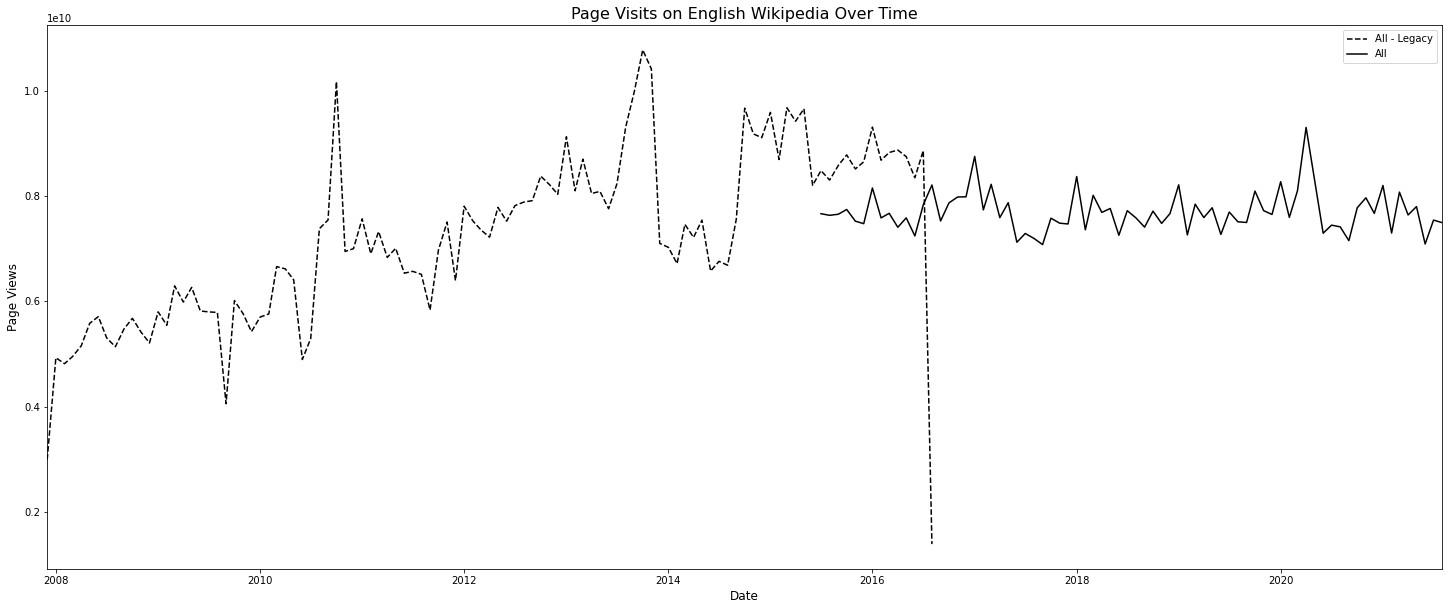

In [145]:
df['date'] = pd.to_datetime(df['year'] * 100 + df['month'], format = '%Y%m')
df.replace(0, np.nan, inplace = True)
# df[df['date'] == max(df['date']) & pd.notnull(df['pagecounts_all_views'])]['pagecounts_all_views']

plt.figure(figsize = (25, 10))
plt.plot(df['date'], df['pagecounts_all_views'], label = 'All - Legacy', linestyle = '--', c = 'black')
plt.plot(df['date'], df['pageviews_all_views'], label = 'All', linestyle = '-', c = 'black')
plt.xlim(min(df['date']), max(df['date']))
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Page Views', fontsize = 12)
plt.title('Page Visits on English Wikipedia Over Time', fontsize = 16)
plt.legend()

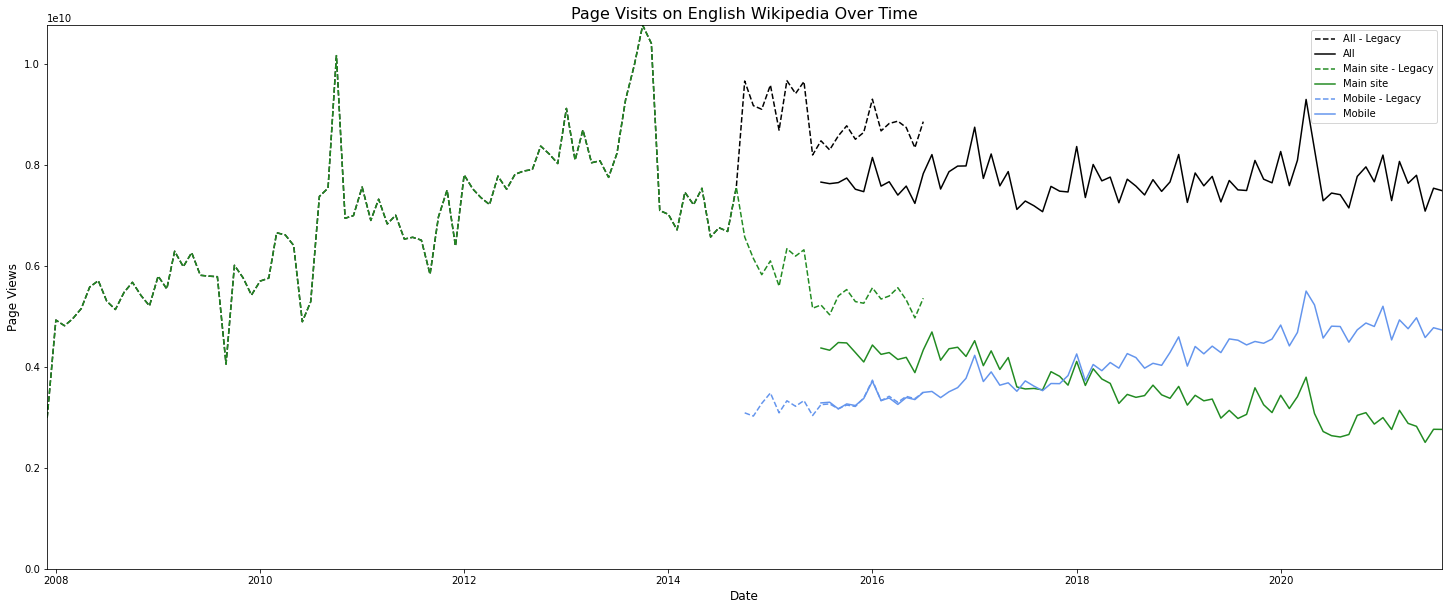

In [146]:
# Last date in the series has a major drop off in views
max_date = max(df.loc[pd.notnull(df['pagecounts_all_views'])]['date'])
df.loc[df['date'] == max_date, ['pagecounts_all_views', 'pagecounts_desktop_views', 'pagecounts_mobile_views']] = np.nan

plt.figure(figsize = (25, 10))
plt.plot(df['date'], df['pagecounts_all_views'], label = 'All - Legacy', linestyle = '--', c = 'black')
plt.plot(df['date'], df['pageviews_all_views'], label = 'All', linestyle = '-', c = 'black')
plt.plot(df['date'], df['pagecounts_desktop_views'], label = 'Main site - Legacy', linestyle = '--', c = 'forestgreen')
plt.plot(df['date'], df['pageviews_desktop_views'], label = 'Main site', linestyle = '-', c = 'forestgreen')
plt.plot(df['date'], df['pagecounts_mobile_views'], label = 'Mobile - Legacy', linestyle = '--', c = 'cornflowerblue')
plt.plot(df['date'], df['pageviews_mobile_views'], label = 'Mobile', linestyle = '-', c = 'cornflowerblue')
plt.xlim(min(df['date']), max(df['date']))
plt.ylim(0, np.max(df['pagecounts_all_views']) + 1000000)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Page Views', fontsize = 12)
plt.title('Page Visits on English Wikipedia Over Time', fontsize = 16)
plt.legend()

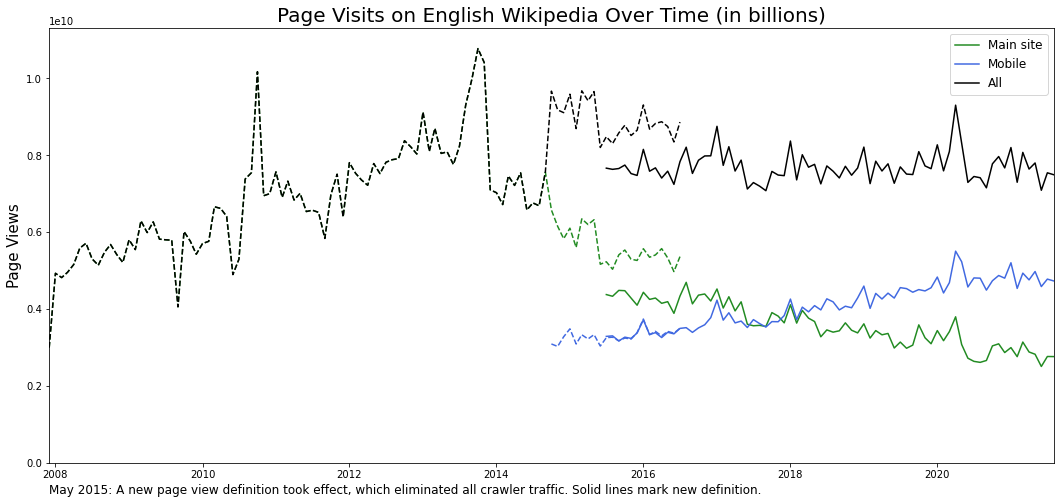

In [168]:
plt.figure(figsize = (18, 8))
plt.plot(df['date'], df['pagecounts_desktop_views'], linestyle = '--', c = 'forestgreen')
plt.plot(df['date'], df['pageviews_desktop_views'], label = 'Main site', linestyle = '-', c = 'forestgreen')
plt.plot(df['date'], df['pagecounts_mobile_views'], linestyle = '--', c = 'royalblue')
plt.plot(df['date'], df['pageviews_mobile_views'], label = 'Mobile', linestyle = '-', c = 'royalblue')
plt.plot(df['date'], df['pagecounts_all_views'], linestyle = '--', c = 'black')
plt.plot(df['date'], df['pageviews_all_views'], label = 'All', linestyle = '-', c = 'black')
plt.xlim(min(df['date']), max(df['date']))
plt.ylim(0, (np.max(df['pagecounts_all_views']) * 1.05))
plt.xlabel('May 2015: A new page view definition took effect, which eliminated all crawler traffic. Solid lines mark new definition.', fontsize = 12, loc = 'left')
plt.ylabel('Page Views', fontsize = 15)
plt.title('Page Visits on English Wikipedia Over Time (in billions)', fontsize = 20)
plt.legend(fontsize = 12)